# Providing presimulated data

In this tutorial, we will demonstrate how one can obtain the posterior with `sbi` from data that been simulated beforehand (for example data that had been simulated on a compute cluster).

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorial/04_presimulated.ipynb](https://github.com/mackelab/sbi/blob/main/tutorial/04_presimulated.ipynb) in the `sbi` repository.

## Main syntax
After having instantiated the inference object (`SNPE`, `SNRE`, or `SNLE`), but before running the inference, we can provide the externally generated data:

In [ ]:
inference = SNPE(simulator, prior)
inference.provide_presimulated(theta, x, from_round=0)
posterior = inference(num_simulations=0)  # num_simulations will be the number of simulations on top of the presimulated data.

## Example with Gaussian likelihood
We now give a full example for how to use presimulated data. We will do this on the previously introduced example of a Uniform prior and Gaussian simulator (see [here](https://www.mackelab.org/sbi/tutorial/00_getting_started/)).

First, we will import the relevant libraries, define the prior and simulator, and make them comply with `sbi`:

In [1]:
import torch
from sbi.inference import SNPE, prepare_for_sbi
import sbi.utils as utils

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Let's now generate simulated data (this step could happen e.g. on a cluster). It does not matter how `x_presimulated` is created from `theta_presimulated`, but `x_presimulated` should be a `torch.tensor` of shape `(number_presimulated, num_dim_x)`:

In [5]:
number_presimulated = 1000
theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = simulator(theta_presimulated)

print('Shape of x_presimulated    : ', x_presimulated.shape)

Shape of x_presimulated    :  torch.Size([1000, 3])


Next, we create the inference object and pass to it the presimulated parameters and presimulated simulation outputs:

In [6]:
inference = SNPE(simulator, prior)
inference.provide_presimulated(theta_presimulated, x_presimulated, from_round=0)

The last argument, `from_round`, indicates what round the presimulated data was drawn from. `from_round=0` means that the parameters were drawn from the prior (see above: `prior.sample((number_presimulated,))`). Later in this tutorial, we will show how one can adjust it if the data did not come from the prior.

We can then run inference. The `num_simulations` argument indicates that number of simulations on top of the presimulated data. In our example, we want to use only presimulated data and not run any new simulations.

In [7]:
posterior = inference(num_simulations=0)

Neural network successfully converged after 133 epochs.


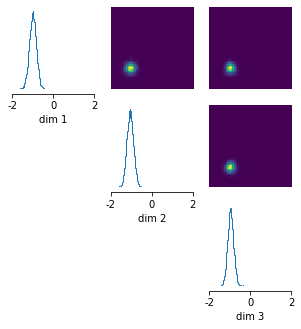

In [8]:
x_o = torch.zeros(1, num_dim)
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

It is also possible to run multi-round inference with presimulated data. In multi-round inference, we simulate new data from the previous estimate of the posterior:

In [9]:
proposal = posterior.set_default_x(x_o)
theta_presimulated_next_round = proposal.sample((1000,))
x_presimulated_next_round = simulator(theta_presimulated_next_round)

We again pass this data to the inference object, this time indicating `from_round=1` (we started counting from `0`, so `1` indicates the second round):

In [12]:
inference.provide_presimulated(theta_presimulated_next_round, x_presimulated_next_round, from_round=1)

...and we can run inference. As shown in [a previous tutorial](http://127.0.0.1:8000/tutorial/02_flexible_interface/), we have to pass the proposal distribution (the one we drew the new parameters `theta_presimulated_next_round` from) to the inference object:

In [13]:
posterior_next_round = inference(num_simulations=0, proposal=proposal)

Using SNPE-C with atomic loss
Neural network successfully converged after 51 epochs.


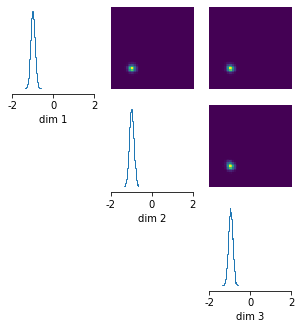

In [14]:
posterior_new_samples = posterior_next_round.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_new_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))